# Projeto 1 - Ciência dos Dados

Nome: Maria Carolina Porto 

Nome: Thomas Kassabian

Nome: Kaique Tinto

Nome: Eduardo Candeias

___
Carregando algumas bibliotecas:

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

___
## Classificador automático


Esse classificador tem por objetivo ensinar um Boot a classificar corretamente os reviews de clientes de uma companhia aérea. Para isso, utilizamos um dataFrame "Train" para treiná-lo, e um dataFrame distinto "Test" para testá-lo.

As possíveis classificações são:
* Detractor: Clientes que expressaram insatisfação ou descontentamento significativo com a companhia aérea;
* Promoter: Clientes extremamente satisfeitos e leais à companhia aérea;
* Passive: Clientes que não expressaram satisfação ou insatisfação com a companhia aérea.

___
## Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

### Preparação dos dados

#### Limpeza e filtragem da base de dados

- Padronização dos dados: removendo letras maiúsculas, pontuações e acentos.
- Filtragem dos dados: removendo stopwords e palavras com duas letras.

In [ ]:
# Função auxiliar que limpa um texto

def cleanup(text):    
    # Retira a pontuação
    punctuation = '[´"!-.:?;$''()]'
    pattern = re.compile(punctuation)
    
    # Retira as stopwords (palavras indiferentes para o cálculo da probabilidade)
    stopwords = ['the','to', 'and', 'was', 'i', 'a', 'in', 'on', 'of', 'with','for', 'flight', 'we']
    words = r'\b(?:' + '|'.join(map(re.escape, stopwords)) + r')\b'
    
    # Retira palavras de duas letras
    limpa_duas_letras = r'\b\w{1,2}\b'
    

    # Aplica as alterações e retorna o texto limpo
    text = re.sub(pattern, '', text)
    text = re.sub(words, '', text, flags=re.IGNORECASE)
    text = re.sub(limpa_duas_letras, '', text)

    return text

#### Gerando a base de dados | Contagem

Aqui, serão obtidas as reviews já limpa. Em seguida, será obtido os dados de frequência das reviews

In [ ]:
# Função auxiliar que recebe um dataframe, limpa e transforma em lista
def transf_lista(dataframe):
    texto = " "

    for linha in dataframe['Review']:
        texto += cleanup(linha)
    
    lista = texto.lower().split()
    return lista

In [ ]:
# Função que recebe um dataframe e retorna as series de cada NPS e suas respectivas frequências (Será usado para obter dados de treinamento)

def contagem(df):
    # Gerando series
    serie_df = pd.Series(transf_lista(df))
    serie_Detractor = pd.Series(transf_lista(df.loc[(df.NPS == 'Detractor'), :]))
    serie_Promoter = pd.Series(transf_lista(df.loc[(df.NPS == 'Promoter'), :]))
    serie_Passive = pd.Series(transf_lista(df.loc[(df.NPS == 'Passive'), :]))

    # Probabilidades por NPS
    P_D = len(serie_Detractor)/len(serie_df)
    P_Pr = len(serie_Promoter)/len(serie_df)
    P_Pa = len(serie_Passive)/len(serie_df)

    # Frequências (absolutas e relativas)
    tabela_df = serie_df.value_counts()
    tabela_Detractor = serie_Detractor.value_counts()
    tabela_Promoter = serie_Promoter.value_counts()
    tabela_Passive = serie_Passive.value_counts()
    tabela_Detractor_relativo = serie_Detractor.value_counts(True)
    tabela_Promoter_relativo = serie_Promoter.value_counts(True)
    tabela_Passive_relativo = serie_Passive.value_counts(True)

    # Return all variables
    return locals()
    
    

#### Classificador
Foram definidas as funções que classificarão as reviews, seguindo o método de Naive-Bayes

In [ ]:
# Função auxiliar que calcula a probabilidade de uma palavra estar em um NPS (classificação) específico

# Recebe: palavra -> palavra que se deseja calcular a probabilidade;
#         tab_NPS -> tabela de um NPS específico;
#         len_serie_NPS -> quantidade de palavras totais (com repetição) em um NPS específico.

def calc_prob(palavra, tab_NPS, len_serie_NPS, tabela_train):
    prob = 1
    # Se a palavra estiver na tabela do NPS específico
    if palavra in tab_NPS:
        prob = ((tab_NPS[palavra] + 1)/(len_serie_NPS + len(tabela_train)))*1e3
        
    # Se a palavra for inédita
    else:   
        prob = (1/(len_serie_NPS + len(tabela_train)))*1e3

    return prob

In [ ]:
# Classifica a frase em detractor, promoter, passive

def classificador(tabela_Detractor, tabela_Passive, tabela_Promoter, tabela_df, serie_Detractor, serie_Passive, serie_Promoter, df, P_NPS):
    classif = []

    # Probabilidades de cada NPS específico
    P_D = P_NPS[0]
    P_Pa = P_NPS[1]
    P_Pr = P_NPS[2]

    # Loop que percorre todos os reviews do dataFrame
    for frase in df.Review:

        #Limpar a frase
        frase_limpa = cleanup(frase).lower().split()
        
        P_frase_dado_D = 1
        P_frase_dado_Pa = 1 
        P_frase_dado_Pr = 1

        # For que percorre cada palavra das frases
        for palavra in frase_limpa:

            #Probabilidade da frase ser de cada NPS específico
            P_frase_dado_D *= calc_prob(palavra, tabela_Detractor, len(serie_Detractor), tabela_df)
            P_frase_dado_Pa *= calc_prob(palavra, tabela_Passive, len(serie_Passive), tabela_df)
            P_frase_dado_Pr *= calc_prob(palavra, tabela_Promoter, len(serie_Promoter), tabela_df)

        #Probabilidade de cada NPS específico para a frase
        P_D_dado_frase = (P_frase_dado_D * P_D)
        P_Pa_dado_frase = (P_frase_dado_Pa * P_Pa)
        P_Pr_dado_frase = (P_frase_dado_Pr * P_Pr)

        # Armazena as probabilidades, compara e adiciona a maior classif na lista 
        prob = [P_D_dado_frase, P_Pa_dado_frase, P_Pr_dado_frase]

        if max(prob) == prob[0]:
            classif.append("Detractor")
        elif max(prob) == prob[1]:
            classif.append("Passive")
        elif max(prob) == prob[2]:
            classif.append("Promoter")
        
    return classif

----
### Treinamento


Obtenção das frequências e probabilidades para cada NPS

In [ ]:
# Dataframe
train = pd.read_csv('dados_treino_QUARTETO_Thomas.csv')

# Contagem
dados = contagem(train)

tabela_Detractor = dados['tabela_Detractor']
tabela_Passive = dados['tabela_Passive']
tabela_Promoter = dados['tabela_Promoter']
tabela_train = dados['tabela_df']
serie_Detractor = dados['serie_Detractor']
serie_Promoter = dados['serie_Promoter']
serie_Passive = dados['serie_Passive']
P_NPS = [dados['P_D'], dados['P_Pa'], dados['P_Pr']]

___
### Testes

#### Classificação

In [ ]:
# Dataframe
test = pd.read_csv('dados_teste_QUARTETO_Thomas.csv')

# Classificação
classificacao_teste = classificador(tabela_Detractor, tabela_Passive, tabela_Promoter, tabela_train, serie_Detractor, serie_Passive, serie_Promoter, test, P_NPS)

#### Verificação os resultados
Comparação do NPS com as classificações fornecidas pelo classificador

In [ ]:
test['Boot'] = classificacao_teste

# Assertividade
acuracia_teste = len(test.loc[(test.NPS == test.Boot), :])/len(test)
print(f'Acurácia: {acuracia_teste*100:.2f}%')

# DF com os reviews classificados corretamente
test.loc[(test.NPS == test.Boot), :]

Crosstab (NPS x Boot)

In [ ]:
pd.crosstab(test.NPS, test.Boot)

Porcentagens

In [ ]:
total_promoter = len(test.loc[test.NPS == 'Promoter', :])
total_passive = len(test.loc[test.NPS == 'Passive', :])
total_detractor = len(test.loc[test.NPS == 'Detractor', :])

# Classificados corretamente
certo_promoter = len(test.loc[(test.NPS == 'Promoter') & (test.Boot == 'Promoter'), :])
certo_passive = len(test.loc[(test.NPS == 'Passive') & (test.Boot == 'Passive'), :])
certo_detractor = len(test.loc[(test.NPS == 'Detractor') & (test.Boot == 'Detractor'), :])

# Classificados incorretamente
errado_promoter = 1 - certo_promoter/total_promoter
errado_passive = 1 - certo_passive/total_passive
errado_detractor = 1 - certo_detractor/total_detractor

# Acurácia
acuracia_test = len(test.loc[(test.NPS == test.Boot), :])/len(test)

# Print
print('Acurácia: {:.2f}%\n'.format(acuracia_test*100))
print(f'Promoter\n Verdadeiros: {certo_promoter/total_promoter*100:.2f}%\n Falsos: {errado_promoter*100:.2f}%\n')
print(f'Passive\n Verdadeiros: {certo_passive/total_passive*100:.2f}%\n Falsos: {errado_passive*100:.2f}%\n')
print(f'Detractor\n Verdadeiros: {certo_detractor/total_detractor*100:.2f}%\n Falsos: {errado_detractor*100:.2f}%\n')

___
### Concluindo

**1. Comparativo entre os percentuais:**

O classificador tende a identificar corretamente reviews classificadas como "Promoter" e "Detractor". Entretanto, reviews referentes a classificação "Passive" possuem elevado índice de erro, com alta tendência a classificar como "Promoter".

Tal análise pode ser observada por meio do crosstab abaixo:

![crosstab](crosstab_analise_boot.png)


**2. Dupla negação e sarcasmo:**

Reviews com dupla negação, que nós humanos identificamos como algo positivo, o classificador identificará como duas vezes algo negativo, aumentando a probabilidade de ser classificada como "Detractor", quando provavelmente não é. Por ooutro lado, reviews com sarcasmo, que nós humanos identificamos como algo negativo, o classificador identificará como algo positivo, aumentando a probabilidade de ser classificada como "Promoter", quando provavelmente não é. 

Ou seja, duplas negações e frases sarcásticas aumentam as chances de classificação incorreta.

**3. Plano de expansão:**

O nosso projeto deve continuar sendo financiado pois a classificação das reviews dos clientes da companhia aérea auxilia positivamente a empresa, uma vez que eles conseguem identificar, por meio de dados concretos, se os clientes estão contentes ou não com os serviços oferecidos. Além disso, é possível identificar quais são os principais pontos de contentamento e descontentamento, os quais, somado a um plano de ação da empresa, possibilitará melhorias na companhia, buscando melhorar os serviços oferecidos e a experiência do usuário. 

Além disso, caso a companhia desejasse enviar reviews positivas e negativas para setores distintos, o classificador removeria a necessidade de que um funcionário lesse cada review e a classificasse, poupando tempo e recursos financeiros da empresa, uma vez que um classificador faria automaticamente tal divisão. 

**4. Diferentes cenários para Naïve Bayes fora do contexto do projeto:**

* Detectar Fake News;

* Detectar mensagens ofensivas/ inapropriadas para, possivelmente, retirar da internet;

**5. Possíveis melhorias para o projeto:**

* Aplicar os métodos stemming e lemmatization na limpeza das frases.

    * Stemming: Analisa cada palavra individualmente e a reduz para o seu radical (não será necessariamente gramaticamente correta);

    * Lemmatization: Analisa cada palavra individualmente e a reduz para o seu radical (será necessariamente gramaticamente correta);

    * Ambos os métodos podem melhorar a nossa ánalise ao juntar palavras difernetes mas com o radical semelhante, alterando a probabilidade final e, portanto, a classificação final (material de pesquisa em "Referências").

* Aplicar metodos de redes neurais, para podermos considerar a semantica e ordem das palavras, com o intuito de aumentar a assertividade do código.


___
### Qualidade do Classificador a partir de novas separações das mensagens entre Treinamento e Teste
Nessa parte, a divisão da base de dados original será refeita em 100 diferentes seeds. O objetivo é entender se a distribução da base de dados afeta (significativamente) a acurácia do classificador.

In [34]:
# Biblioteca necessária para dividir o dataframe em treino e teste
from sklearn.model_selection import train_test_split

In [ ]:
# Reintegrando os dataframes em um só
dados = pd.concat([train, test]).drop(columns=['Boot'])

# Lista de acurácias
acuracias = []

# Loop para testar diferentes seeds
for i in range(100):
    # Obtendo os dados de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(dados.Review, dados.NPS, test_size=0.3, random_state=i)
    dados_treino = pd.concat([X_train, y_train], axis=1)
    dados_teste = pd.concat([X_test, y_test], axis=1)

    # Contagem dos dados de treino
    dados_treino = contagem(dados_treino)
    tabela_Detractor = dados_treino['tabela_Detractor']
    tabela_Passive = dados_treino['tabela_Passive']
    tabela_Promoter = dados_treino['tabela_Promoter']
    tabela_train = dados_treino['tabela_df']
    serie_Detractor = dados_treino['serie_Detractor']
    serie_Promoter = dados_treino['serie_Promoter']
    serie_Passive = dados_treino['serie_Passive']
    P_NPS = [dados_treino['P_D'], dados_treino['P_Pa'], dados_treino['P_Pr']]

    # Classificação
    classificacao_teste = classificador(tabela_Detractor, tabela_Passive, tabela_Promoter, tabela_train, serie_Detractor, serie_Passive, serie_Promoter, dados_teste, P_NPS)
    dados_teste['Boot'] = classificacao_teste

    # Acurácia
    acuracia_teste = len(dados_teste.loc[(dados_teste.NPS == dados_teste.Boot), :])/len(dados_teste)
    acuracias.append(acuracia_teste)

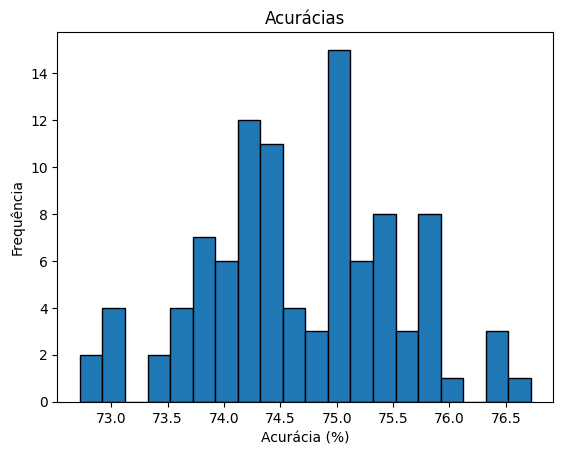

In [33]:
# Histograma
acuracias_porcentagem = [acuracia * 100 for acuracia in acuracias]
plt.hist(acuracias_porcentagem, bins=20, edgecolor='k', density=False)

plt.title('Acurácias')
plt.xlabel('Acurácia (%)')
plt.ylabel('Frequência')
plt.show()

#### Conclusão
Como é possível observar no histograma, alterar a base de dados **não afeta significativamente** a eficácia do classificador, apresentando uma variação máxima de +/- 2% em relação ao primeiro teste. Isso ocorre porque o classificador é feito com o intuito de **generalizar as informações** apresentadas, e **não memorizar** casos específicos. Dessa forma, variações na organização dos dados, que seguem um mesmo padrão, não afetam significativamente a performance do programa.

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* OK IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nas mensagens. Ex: stemming, lemmatization, stopwords
* OK CONSIDEROU arquivo com três categorias na classificação das variáveis (OBRIGATÓRIO PARA QUARTETOS, sem contar como item avançado)
* OK CONSTRUIU o cálculo das probabilidades corretamente utilizando bigramas E apresentou referência sobre o método utilizado.
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* OK PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários diferentes, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* OK SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das mensagens entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)


___
## Itens avançados:

1) Porque não pode usar o próprio classificador para gerar mais amostras de treinamento?
* Não podemos usar o proprio classificador para gerar mais amostras de treinamento, pois o classificador já foi treinado com esses dados.
2) Diferentes cenários para Naïve Bayes fora do contexto do projeto:
* Detectar Fake News;
* Detectar mensagens ofensivas/ inapropriadas para, possivelmente, retirar da internet;
3) Possíveis melhorias para o projeto:
* Aplicar os métodos stemming e lemmatization na limpeza das frases.
Stemming: Analisa cada palavra individualmente e a reduz para o seu radical (não será necessariamente gramaticamente correta);
Lemmatization: Analisa cada palavra individualmente e a reduz para o seu radical (será necessariamente gramaticamente correta);
Ambos os métodos podem melhorar a nossa ánalise ao juntar palavras difernetes mas com o radical semelhante, alterando a probabilidade final e, portanto, a classificação final.
Material de pesquisa em "Referências"

* Aplicar metodos de redes neurais, para podermos considerar a semantica e ordem das palavras, com o intuito de aumentar a assertividade do código.
 

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

[Lemmatization vs. stemming: quando usar cada uma?](https://www.alura.com.br/artigos/lemmatization-vs-stemming-quando-usar-cada-uma) **Diferenças entre Lemmatization e stemming, e como aplicar cada uma**

[Como uma rede neural Aprende?](https://youtu.be/mWD8wWwZpi8?si=sxqbkwEUJLPiLUMs) **Utilização de redes neurais para melhorar a assertividade do codigo.**


In [ ]:
# O modelo probabilistico para o calculo e classificação de texto, se baseia na probabilidade de uma palavra estar em um NPS específico. Fizemos o uso do metodo de Naive Bayes para calcular a probabilidade de uma palavra estar em um NPS específico. Com o intuito de minimizar os erros e maximizar a porcentagem de acertividade, aplicamos a suavização de Laplace dentro do código 